# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2023
## Домашнее задание 4. Линейные модели
### Мягкий дедлайн --- 25.11 23:59
### Жесктий дедлайн --- 30.11 16:59

Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.


В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения. Для этого вам понадобится библиотека `scipy.stats`. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook c:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается **в 10 баллов**.

In [2]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

В учебных целях в первой задаче запрещено использовать готовые реализации линейной регрессии (например, из пакета *scikit-learn*).

## Задача 1 (10 баллов)

На полигоне испытывается новая модель трамвая. В одном из испытании работы двигателя проверяется, что движение трамвая равномерно. Для проведения теста на трамвай установлен датчик, посекундно измеряющий пройденное расстояние.

Записи датчика можно описать такой моделью:

 $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$

где $X_i$ --- расстояние, которое проехал трамвай за $i$ секунд. В модели $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 1, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ --- ошибка отсчета времени. Все ошибки $\varepsilon_i^t$ независимы и распределены по закону $N(0, \sigma^2)$.

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для $\sigma^2,$ из которой выразите оценку дисперсии отсчета времени.

Данные возьмите из файла Regression.csv. Сделайте выводы.

### Решение

Загрузим датасет, содержащий показания датчика.

In [3]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1pJSA_OGMHu2Ks__Wqf0digi3RAz7Wg7J

Downloading...
From: https://drive.google.com/uc?id=1pJSA_OGMHu2Ks__Wqf0digi3RAz7Wg7J
To: /content/regression.csv
100% 9.98k/9.98k [00:00<00:00, 30.5MB/s]


Датасет состоит из 1000 измерений. По смыслу средняя скорость имеет размерность метры в секунду.

In [4]:
X = np.genfromtxt('regression.csv')
print('Размер датасета:', X.shape)
print('Средняя скорость:', X[-1] / X.shape[0])

Размер датасета: (1000,)
Средняя скорость: 12.0408175


Визуализируйте выборку и сделайте выводы о том, верно ли что линейная регрессионная модель имеет смысл

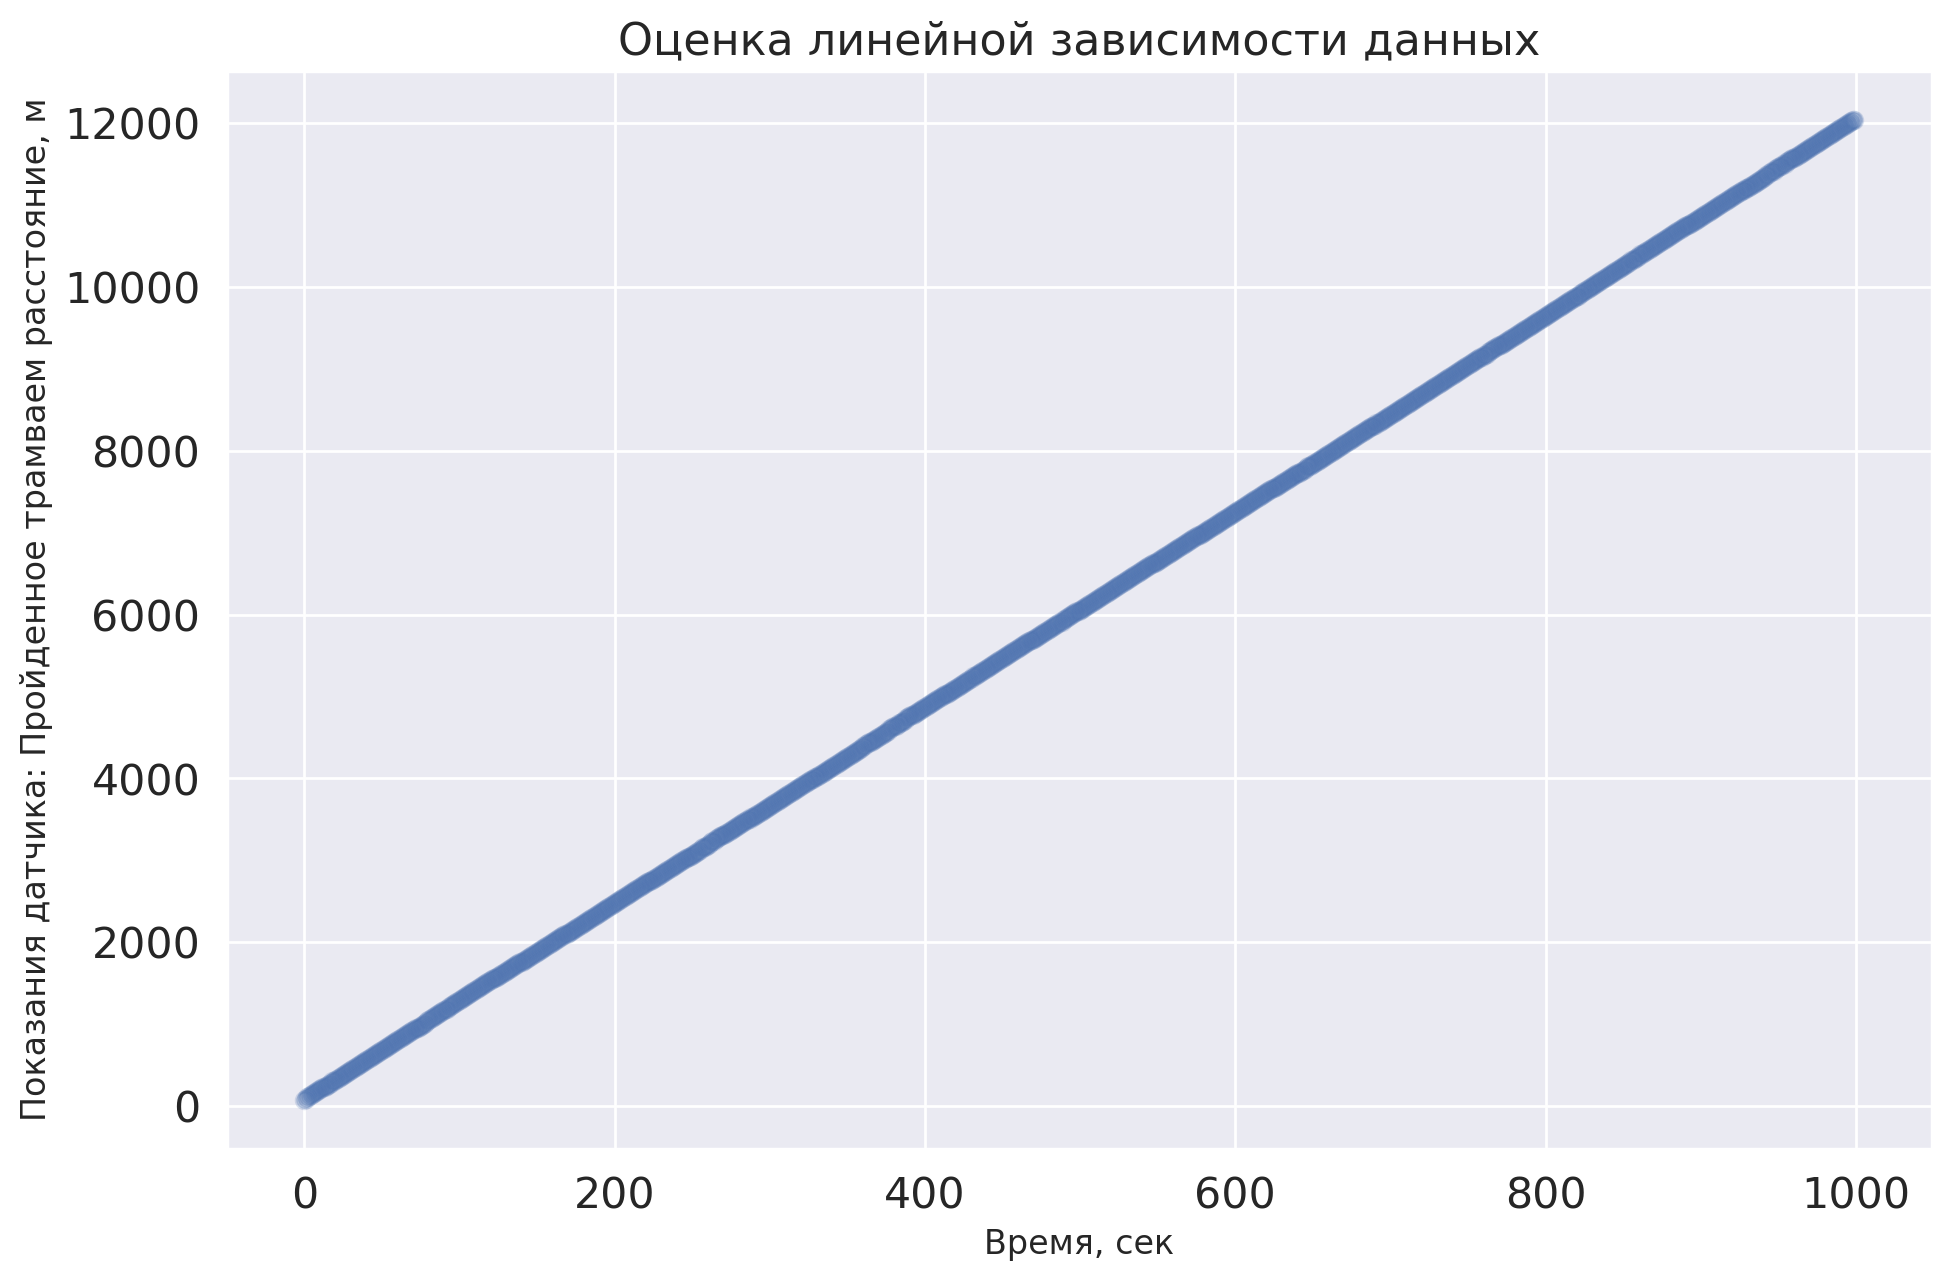

In [5]:
time = np.arange(X.shape[0])

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(11, 7))
    plt.scatter(x=time, y=X, alpha=0.2)
    plt.title("Оценка линейной зависимости данных", fontsize=16)
    plt.xlabel("Время, сек", fontsize=12)
    plt.ylabel("Показания датчика: Пройденное трамваем расстояние, м", fontsize=12)
    plt.show()

Из визуализации видно, что данные имеют примерно линейную зависимость, что свидетельствует о применимости линейной модели.

#### 1. Сведите задачу к гауссовской линейной модели (определения брать из основного курса)

**Сведение к Гауссовской линейной регрессии**:

$$
\varepsilon_0 \sim N(0, \sigma^2\beta_2^2), \quad \varepsilon_j \sim N(0, \sigma^2\beta_2^2).
$$

Тогда:
$$
\varepsilon_0 + \sum_{j=1}^i \varepsilon_j \sim N\left(0, \sigma^2\beta_2^2(i+1)\right).
$$

Введем:
$$
X_{new} =
\begin{bmatrix}
X_0 \\
\frac{X_1}{\sqrt{2}} \\
\frac{X_2}{\sqrt{3}} \\
\vdots \\
\frac{X_n}{\sqrt{n + 1}}
\end{bmatrix} = \begin{bmatrix}
1 & 0 \\
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{3}} & \frac{2}{\sqrt{3}} \\
\vdots & \vdots \\
\frac{1}{\sqrt{n+1}} & \frac{n}{\sqrt{n+1}}
\end{bmatrix} \cdot \begin{bmatrix}
\beta_1 \\
\beta_2
\end{bmatrix} + \varepsilon
$$

Тут $\varepsilon$:
$$
\begin{bmatrix}
\varepsilon_0 \\
(\varepsilon_0 + \varepsilon_1) \frac{1}{\sqrt{2}} \\
\vdots \\
(\varepsilon_0 + \varepsilon_1 + ... + \varepsilon_n) \frac{1}{\sqrt{n + 1}} \\
\end{bmatrix}
$$

Теперь дисперсия ошибки одинакова для всех координат и равна $\sigma^2 \beta_2^2$. Ошибки имеют одинаковое нормальное распределение.

$$
Z =
\begin{bmatrix}
1 & 0 \\
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{3}} & \frac{2}{\sqrt{3}} \\
\vdots & \vdots \\
\frac{1}{\sqrt{n+1}} & \frac{n}{\sqrt{n+1}}
\end{bmatrix}
,\quad
\beta =
\begin{bmatrix}
\beta_1 \\
\beta_2
\end{bmatrix}.
$$

Модель принимает вид:
$$
X_{new} = Z \beta + \varepsilon,
$$
где ошибка $\varepsilon$ имеет распределение $N(0, \sigma^2 \beta^2_2)$.

В силу того, что $\beta_1$ в выборке присутствует всего лишь в одном месте, этот параметр влияет на данные только в одной точке. По этой причине, на мой взгляд, корректно оценить $\beta_1$ будет значительно сложнее, чем второй параметр, $\beta_2$, который присутствует во всех данных, кроме первой координаты.

In [264]:
weights = 1 / np.sqrt(np.arange(1, X.shape[0] + 1))
X_new = X * weights

#### 2. Найдите оценку параметров

Укажите, чему равна матрица (Z в терминах методички) в задаче:


$$
Z =
\begin{bmatrix}
1 & 0 \\
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{3}} & \frac{2}{\sqrt{3}} \\
\vdots & \vdots \\
\frac{1}{\sqrt{n+1}} & \frac{n}{\sqrt{n+1}}
\end{bmatrix}
$$


In [273]:
Z = np.vstack((weights, weights * np.arange(X.shape[0])))
Z = Z.T

Z

array([[ 1.        ,  0.        ],
       [ 0.70710678,  0.70710678],
       [ 0.57735027,  1.15470054],
       ...,
       [ 0.03165445, 31.55948355],
       [ 0.0316386 , 31.57532266],
       [ 0.03162278, 31.59115383]])

И найдите параметры $\beta_1$, $\beta_2$



Оценки коэффициентов:
$$
\hat{\beta} = (Z^T Z)^{-1} Z^T X_{new}.
$$

In [262]:
def BetaEstimation(Z, X):
    return np.linalg.inv(Z.T @ Z) @ Z.T @ X

Посчитаем оценки параметров $\beta_1, \beta_2$.

In [274]:
beta_1, beta_2 = BetaEstimation(Z, X_new)

print(f"beta_1 = {beta_1}")
print(f"beta_2 = {beta_2}")

beta_1 = 85.62200289468441
beta_2 = 11.954178410421056


Оценим параметры модели с помощью `numpy.polyfit`, который решает задачу методом линейной регрессии. Однако стоит понимать, что в данном случае мы используем линейную модель немного некорректно, поскольку ошибка не одинаково распределена по всем координатам. Тем не менее, для сравнения результатов это подойдёт.

In [275]:
np_beta_2, np_beta_1 = np.polyfit(x=time, y=X, deg=1)

print(f"numpy beta_1 = {np_beta_1}")
print(f"numpy beta_2 = {np_beta_2}")

numpy beta_1 = 85.95216213666387
numpy beta_2 = 11.953517430957628


В целом результаты, полученные нашей линейной моделью и с помощью `np.polyfit`, почти не отличаются.

*Ошибкой* или *остатком* называют разность между наблюдаемым значением целевой величины и предсказанием модели на основе соответствующих признаков. Проверьте, насколько точна модель при помощи подсчёта ошибок. Выведите сами ошибки на график и проанализируйте его.

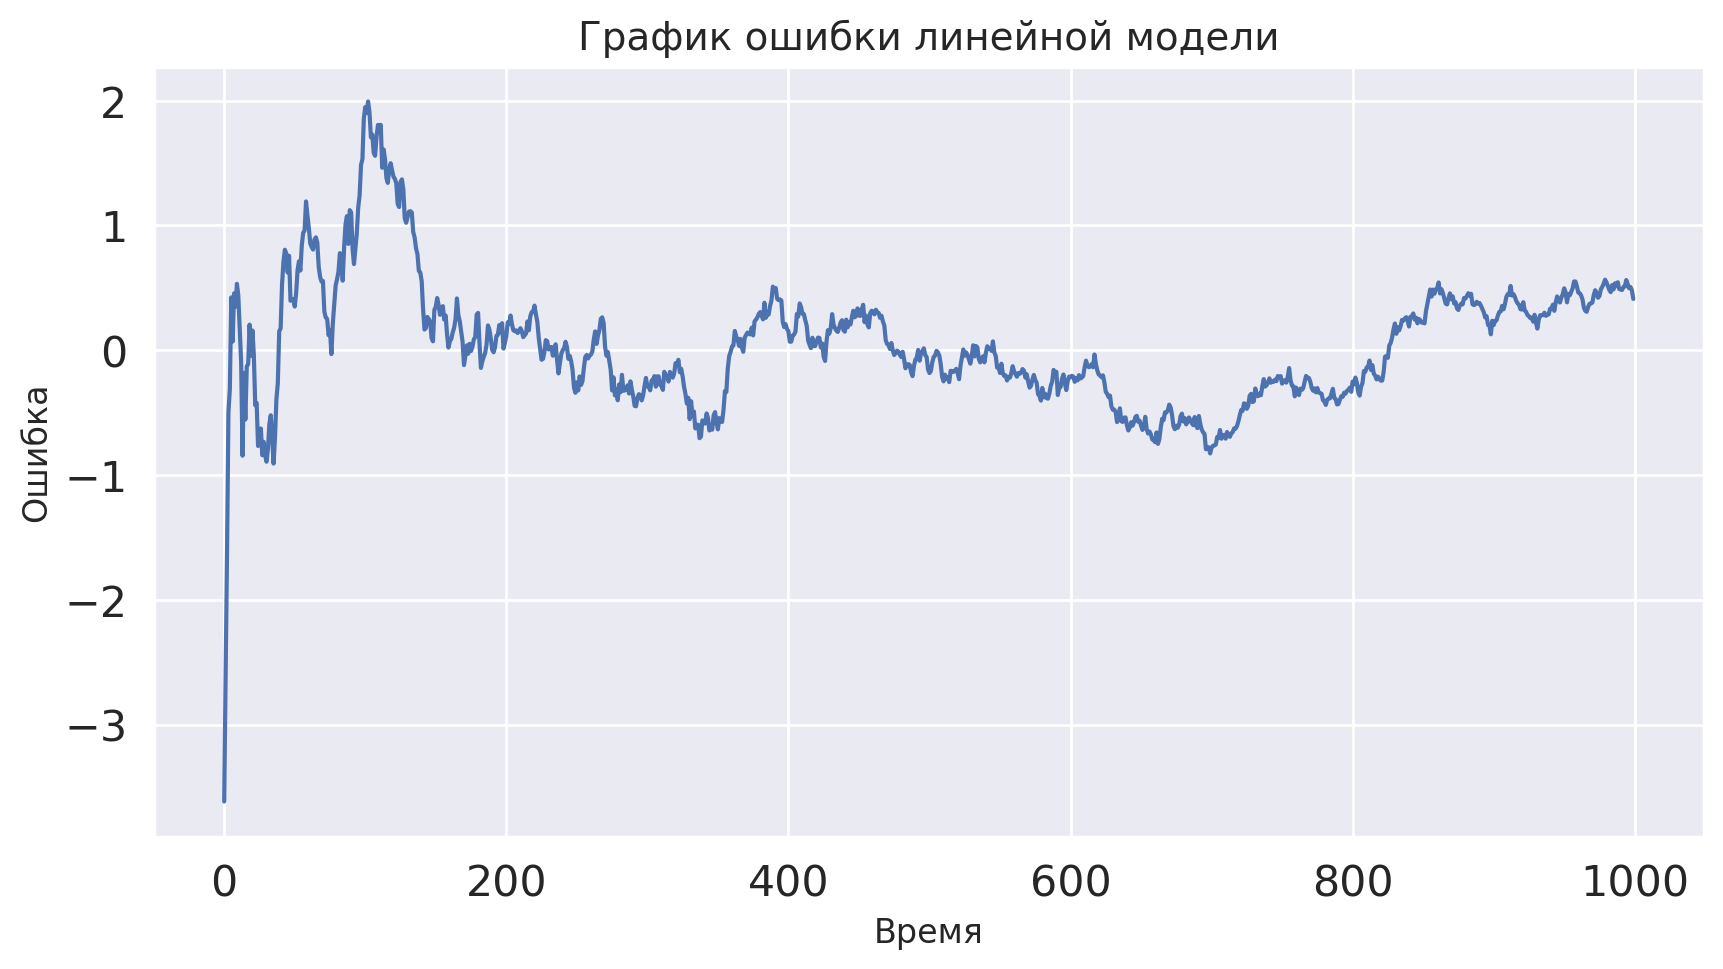

In [291]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    plt.plot(time, X_new - Z @ [beta_1, beta_2])

    plt.xlabel("Время", fontsize=12)
    plt.ylabel("Ошибка", fontsize=12)
    plt.title("График ошибки линейной модели", fontsize=14)

    plt.show()

Проверьте, что ошибка нормальна. Для этого можно использовать QQ-plot. Если хотите, можете использовать критерии нормальности

In [277]:
predicted = Z @ [beta_1, beta_2]
errors = X_new - predicted

np_predicted = np.polyval(np.polyfit(x=time, y=X, deg=1), time)
np_errors = X - np_predicted

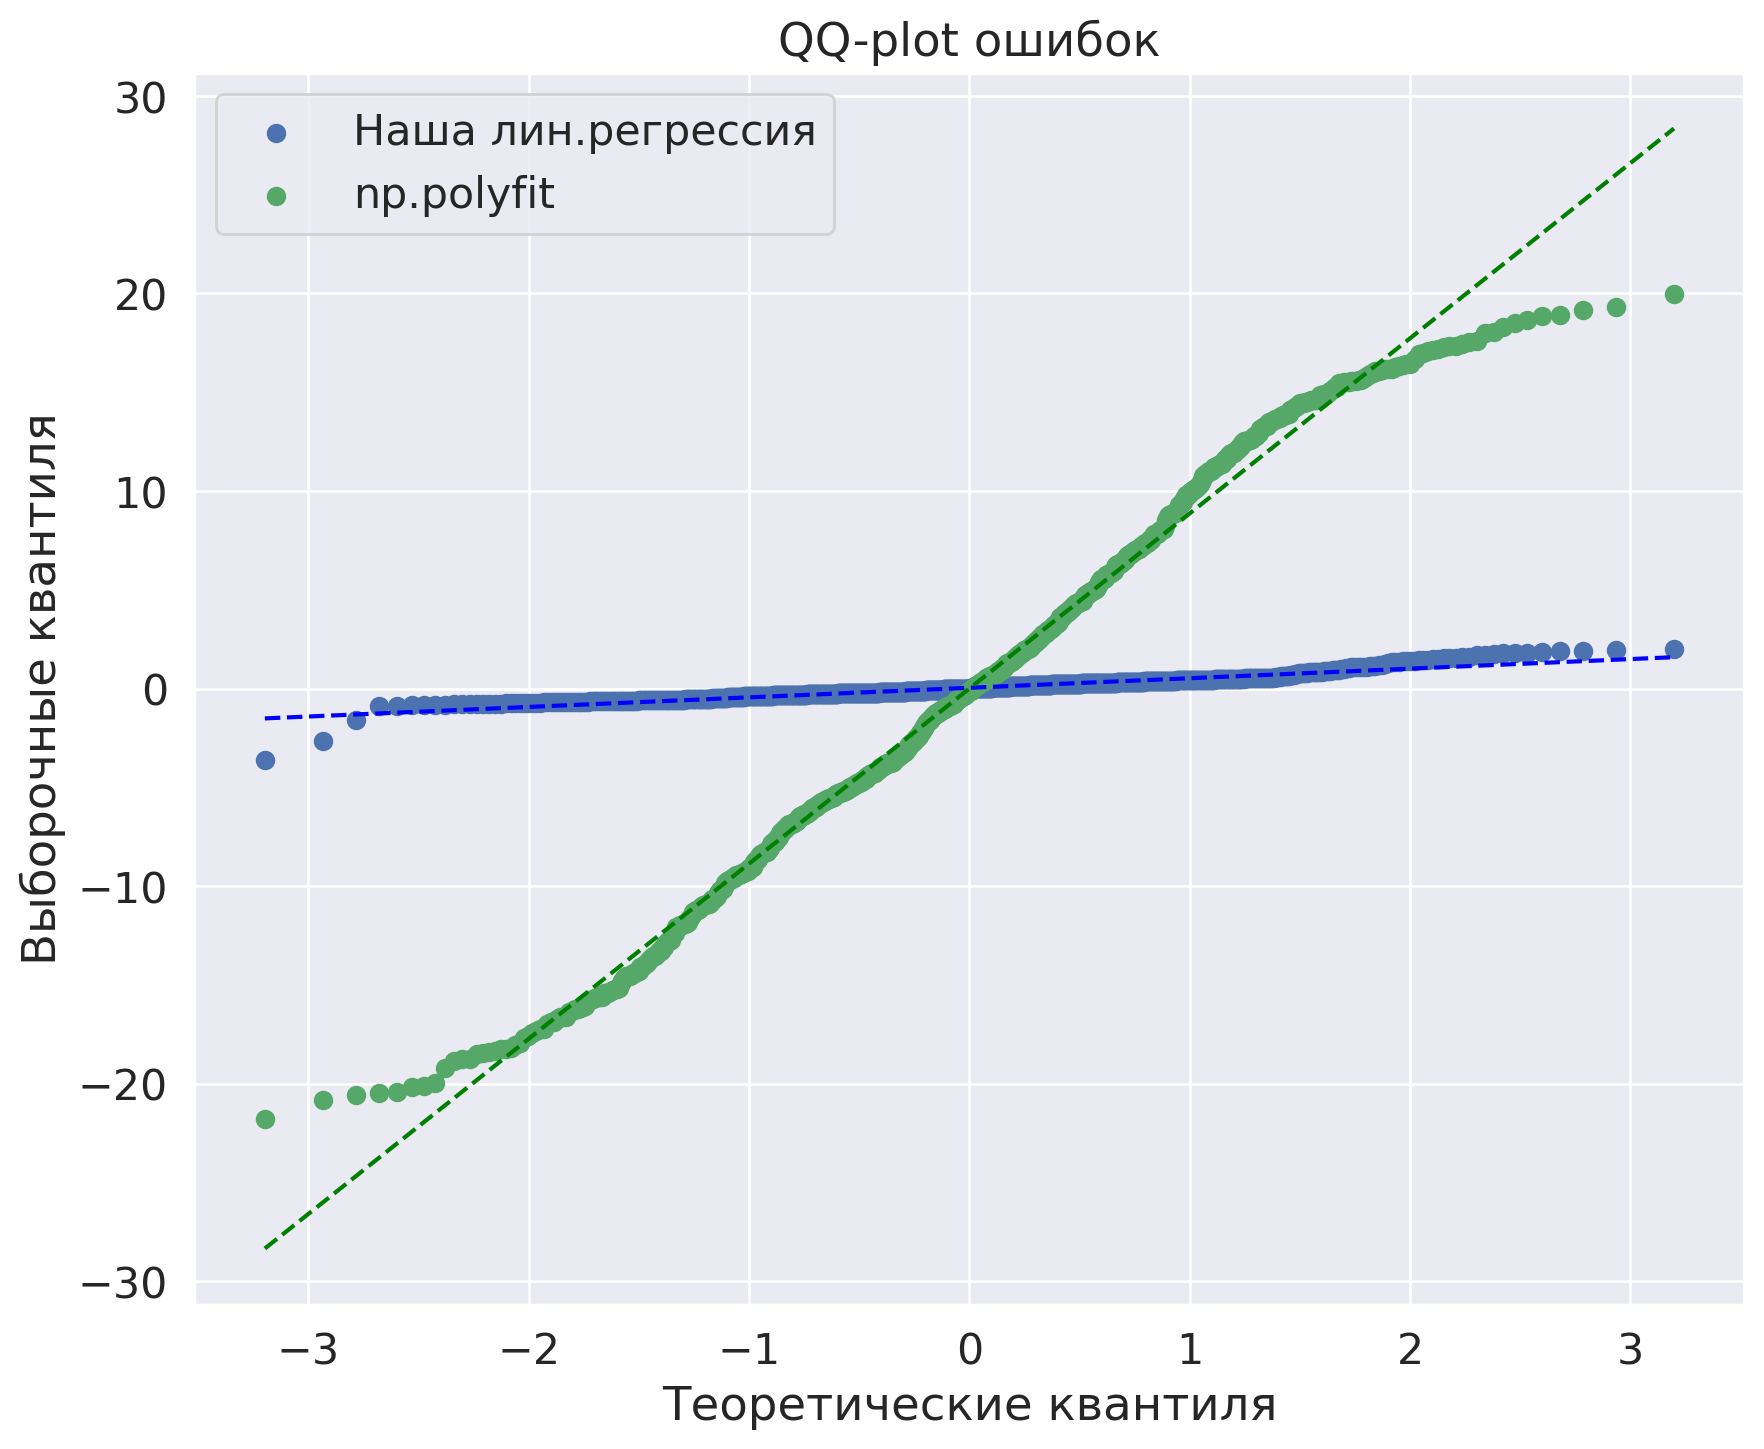

In [278]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 8))

    probplot, theor_line = sps.probplot(errors, dist="norm")
    plt.scatter(probplot[0], probplot[1], color="b", label="Наша лин.регрессия")

    np_probplot, np_theor_line = sps.probplot(np_errors, dist="norm")
    plt.scatter(np_probplot[0], np_probplot[1], color="g", label="np.polyfit")

    plt.plot(probplot[0], theor_line[0] * probplot[0] + theor_line[1], color="blue", linestyle="--")
    plt.plot(np_probplot[0], np_theor_line[0] * np_probplot[0] + np_theor_line[1], color="green", linestyle="--")

    plt.title("QQ-plot ошибок")
    plt.xlabel("Теоретические квантиля")
    plt.ylabel("Выборочные квантиля")

    plt.legend()
    plt.show()

Как и ожидалось, ошибка у нашей модели имеет нормальное распределение, чего нельзя сказать об ошибке `np.polyfit`.

Бонусная часть (+5 баллов):

Возможно измерения в задаче содержат разные аномалии, что плохо скажется на оценке наименьших квадратов. Попробуйте применить знания из предыдущей домашки о робастных оценках и построить оценку с BP выше нуля. Такие методы называются "робастной регрессией", но определение M-оценки в них то же, что и в обычной робастной статистике.

#### 3. Оцените дисперсию ошибки показаний датчика.

Найдите оценку дисперсии ошибка приращения расстояния $\varepsilon_i$. По ней найдите оценку дисперсию ошибки отсчёта времени $\varepsilon_i^t$.

Оценка дисперсии $\varepsilon_i$:
$$
\hat{\sigma}^2 = \frac{1}{n-2} ||X_{new} - Z \hat{\beta}||^2.
$$

Оценка дисперсии $\varepsilon_i^t$:
$$
\hat{\sigma_{t}}^2 = \frac{\hat{\sigma}^2}{\hat{\beta_2}^2}.
$$

In [14]:
def SigmaEstimation(Z, X, beta):
    n = X.shape[0]
    return np.linalg.norm(X - Z @ beta) ** 2 / (n - 2)


def TimeSigmaEstimation(Z, X, beta):
    return SigmaEstimation(Z, X, beta) / beta[1]**2

Считаем оценки.

In [280]:
sigma = SigmaEstimation(Z, X_new, [beta_1, beta_2])
sigma_time = TimeSigmaEstimation(Z, X_new, [beta_1, beta_2])

print(f"Дисперсия (sigma_time) = {sigma_time}")
print(f"Дисперсия (sigma) = {sigma}")

Дисперсия (sigma_time) = 0.0017737948373949422
Дисперсия (sigma) = 0.2534795064996948


#### 4. Измерьте качество модели

$R_2$ оценка качества модели.

In [284]:
from sklearn.metrics import r2_score

predicted = beta_1 + beta_2 * time

r2 = r2_score(X, predicted)
np_r2 = r2_score(X, np_predicted)

print(f"R2 оценка качества нашей линейной модели {r2 * 100:.8}%")
print(f"R2 оценка качества np.polyfit {np_r2 * 100:.8}%")

R2 оценка качества нашей линейной модели 99.999337%
R2 оценка качества np.polyfit 99.999338%


**Вывод:**

## Задача 2 (5 баллов)

Непараметрическая регрессия и метод Надарая-Ватсона.

Иногда вытаскивать информативные признаки из данных сложно, а регрессию делать хочется. Тогда можно построить нечто похожее на ядерную оценку плотности, но для регрессионной задачи. Она основана на вычислении значения в новой точке по значениям в соседних точках (похожее Вы видели на курсе машинного обучения, но для классификации и без статистики).

Изучите формулу Надарая-Ватсона из статьи на википедии: https://en.wikipedia.org/wiki/Kernel_regression

1) Сгенерируйте выборку для линейной регрессии руками (использовать реальные данные может быть нецелесообразно из-за проблем с визуализацией результата и проклятия размерностей).

Пусть в модели будет одна фича $x$ и по ней вычисляется отклик $y = ax + b + \varepsilon$, где ошибка независима и нормальна, а параметры $a$ и $b$ выберите сами.

Фиксируем для воспроизводимости.

In [139]:
np.random.seed(42)

Генерация данных.

In [140]:
n = 2 * 10**2
a, b = 3, 10

x_train = np.linspace(0, 200, n)
eps_train = sps.norm.rvs(loc=0, scale=1, size=n)
y_train = a * x_train + b + eps_train

Сгенерируйте тестовую выборку тем же способом и посчитайте отклик из формулы Надарая-Ватсона для хотя бы трёх разных ядер (примеры ядер: https://en.wikipedia.org/wiki/Kernel_(statistics)). Сравните ошибки.

Тестовая выборка.

In [143]:
n_test = 10**3

x_test = np.linspace(50, 150, n_test)
eps_test = sps.norm.rvs(loc=0, scale=1, size=n_test)
y_test = a * x_test + b + eps_test

Визуализация данных.

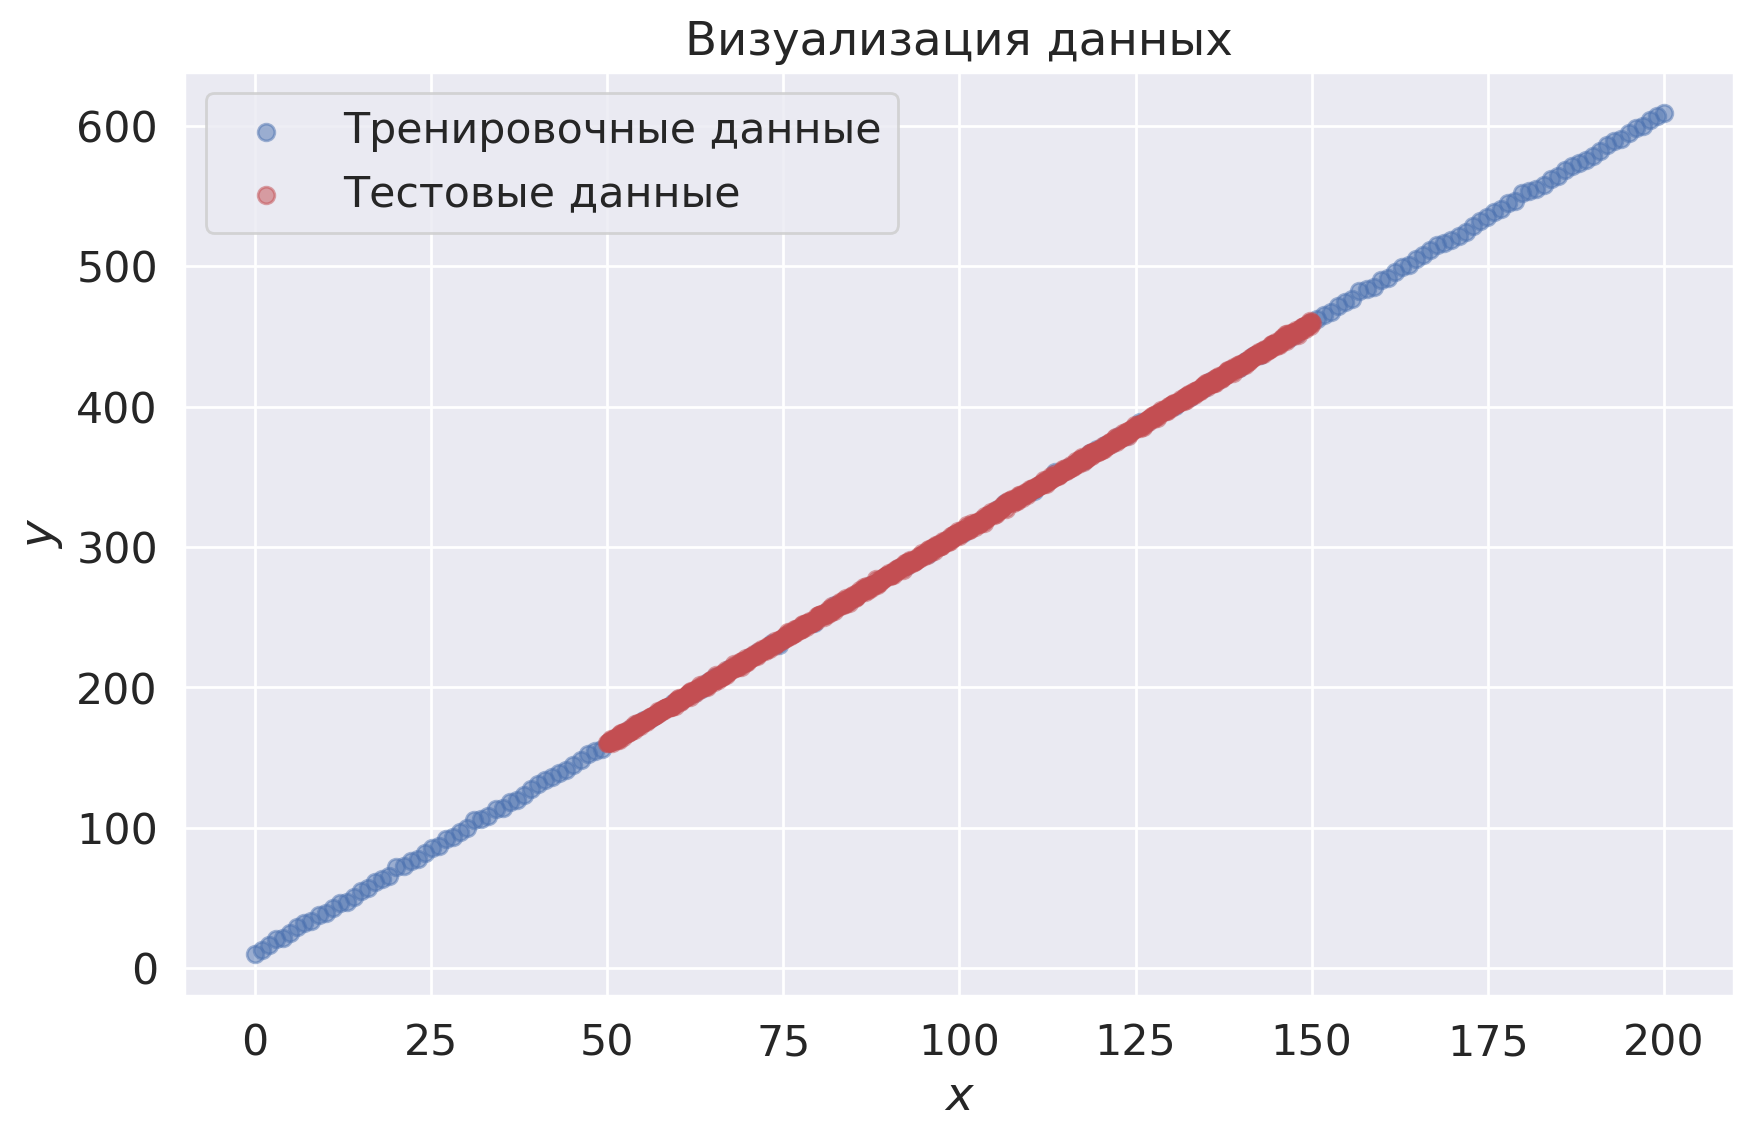

In [160]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 6))

    plt.scatter(x_train, y_train, alpha=0.5, color='b', label='Тренировочные данные')
    plt.scatter(x_test, y_test, alpha=0.5, color='r', label='Тестовые данные')

    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title("Визуализация данных")

    plt.legend()
    plt.show()

1. Гауссовское ядро:
$$
K(u) = \frac{1}{\sqrt{2 \pi}}\exp(- \frac{u^2}{2})
$$

2. Ядро Епанечникова:

$$
K(u) =
\begin{cases}
\frac{3}{4}(1 - u^2), & \text{если } |u| \leq 1, \\
0, & \text{если } |u| > 1.
\end{cases}
$$

3. Сигмоидальное ядро:

$$
K(u) = \frac{2}{\pi} \frac{1}{e^{u} + e^{-u}}
$$

4. Триквадратное ядро:

$$
K(u) =
\begin{cases}
\frac{35}{32}(1 - u^2)^3, & \text{если } |u| \leq 1, \\
0, & \text{если } |u| > 1.
\end{cases}
$$


In [179]:
def gaussian_kernel(u):
    return np.exp(-u ** 2 / 2) / np.sqrt(2 * np.pi)


def epanechnikov_kernel(u):
    return (np.abs(u) <= 1) * (3 / 4) * (1 - u ** 2)


def sigmoid_kernel(u):
    return (2 / np.pi) / (np.exp(u) + np.exp(-u))


def triangular_kernel(u):
    return (np.abs(u) <= 1) * (35 / 32) * (1 - u ** 2) ** 3

Регрессия Надаря-Ватсона:
$$
\hat{y}(x_0) = \frac{\sum_{i=1}^n K\left(\frac{x_0 - x_i}{h}\right) y_i}{\sum_{i=1}^n K\left(\frac{x_0 - x_i}{h}\right)}
$$

In [174]:
def nadaraya_watson(x_train, y_train, x_test, kernel, bandwidth = 1):
    K = kernel((x_test[:, np.newaxis] - x_train[np.newaxis, :]) / bandwidth)
    down = 1 * (np.sum(K, axis=1) == 0) + np.sum(K, axis=1) * (np.sum(K, axis=1) != 0)

    return np.sum(K * y_train[np.newaxis, :], axis=1) / down

Проведем регрессию (считаем отклик).

In [180]:
y_predicted_gauss = nadaraya_watson(x_train, y_train, x_test, gaussian_kernel)
y_predicted_epanechniko = nadaraya_watson(x_train, y_train, x_test, epanechnikov_kernel)
y_predicted_sigmoid = nadaraya_watson(x_train, y_train, x_test, sigmoid_kernel)
y_predicted_triangular = nadaraya_watson(x_train, y_train, x_test, triangular_kernel)

Сравнение ошибок.

In [181]:
mae_gauss = np.mean(np.abs(y_predicted_gauss - y_test))
mae_epanechnikov = np.mean(np.abs(y_predicted_epanechniko - y_test))
mae_sigmoid = np.mean(np.abs(y_predicted_sigmoid - y_test))
mae_triangular = np.mean(np.abs(y_predicted_triangular - y_test))

print("Средняя абсолютная ошибка (MAE) для различных ядер:")
print(f"Гауссовское ядро: {mae_gauss:.4f}")
print(f"Ядро Епанечникова: {mae_epanechnikov:.4f}")
print(f"Сигмоидальное ядро: {mae_sigmoid:.4f}")
print(f"Треугольное ядро: {mae_triangular:.4f}")

Средняя абсолютная ошибка (MAE) для различных ядер:
Гауссовское ядро: 0.8552
Ядро Епанечникова: 0.9806
Сигмоидальное ядро: 0.8277
Треугольное ядро: 1.0557


Результаты на самом деле логичны. Гауссовское и сигмоидальное ядра не имеют таких резких пиков, как ядро Епанечникова и треугольное ядро. Из-за этого итоговый отклик получается более гладким (то есть без резких изменений). Это, в свою очередь, снижает общую ошибку.

Визуализируйте Ваши предсказания (постройте кривую предсказаний по сетке x с шагом 0.01)

In [184]:
step = 0.01
x_grid = np.arange(98, 102, step)

y_gauss = nadaraya_watson(x_train, y_train, x_grid, gaussian_kernel)
y_epanechniko = nadaraya_watson(x_train, y_train, x_grid, epanechnikov_kernel)
y_sigmoid = nadaraya_watson(x_train, y_train, x_grid, sigmoid_kernel)
y_triangular = nadaraya_watson(x_train, y_train, x_grid, triangular_kernel)

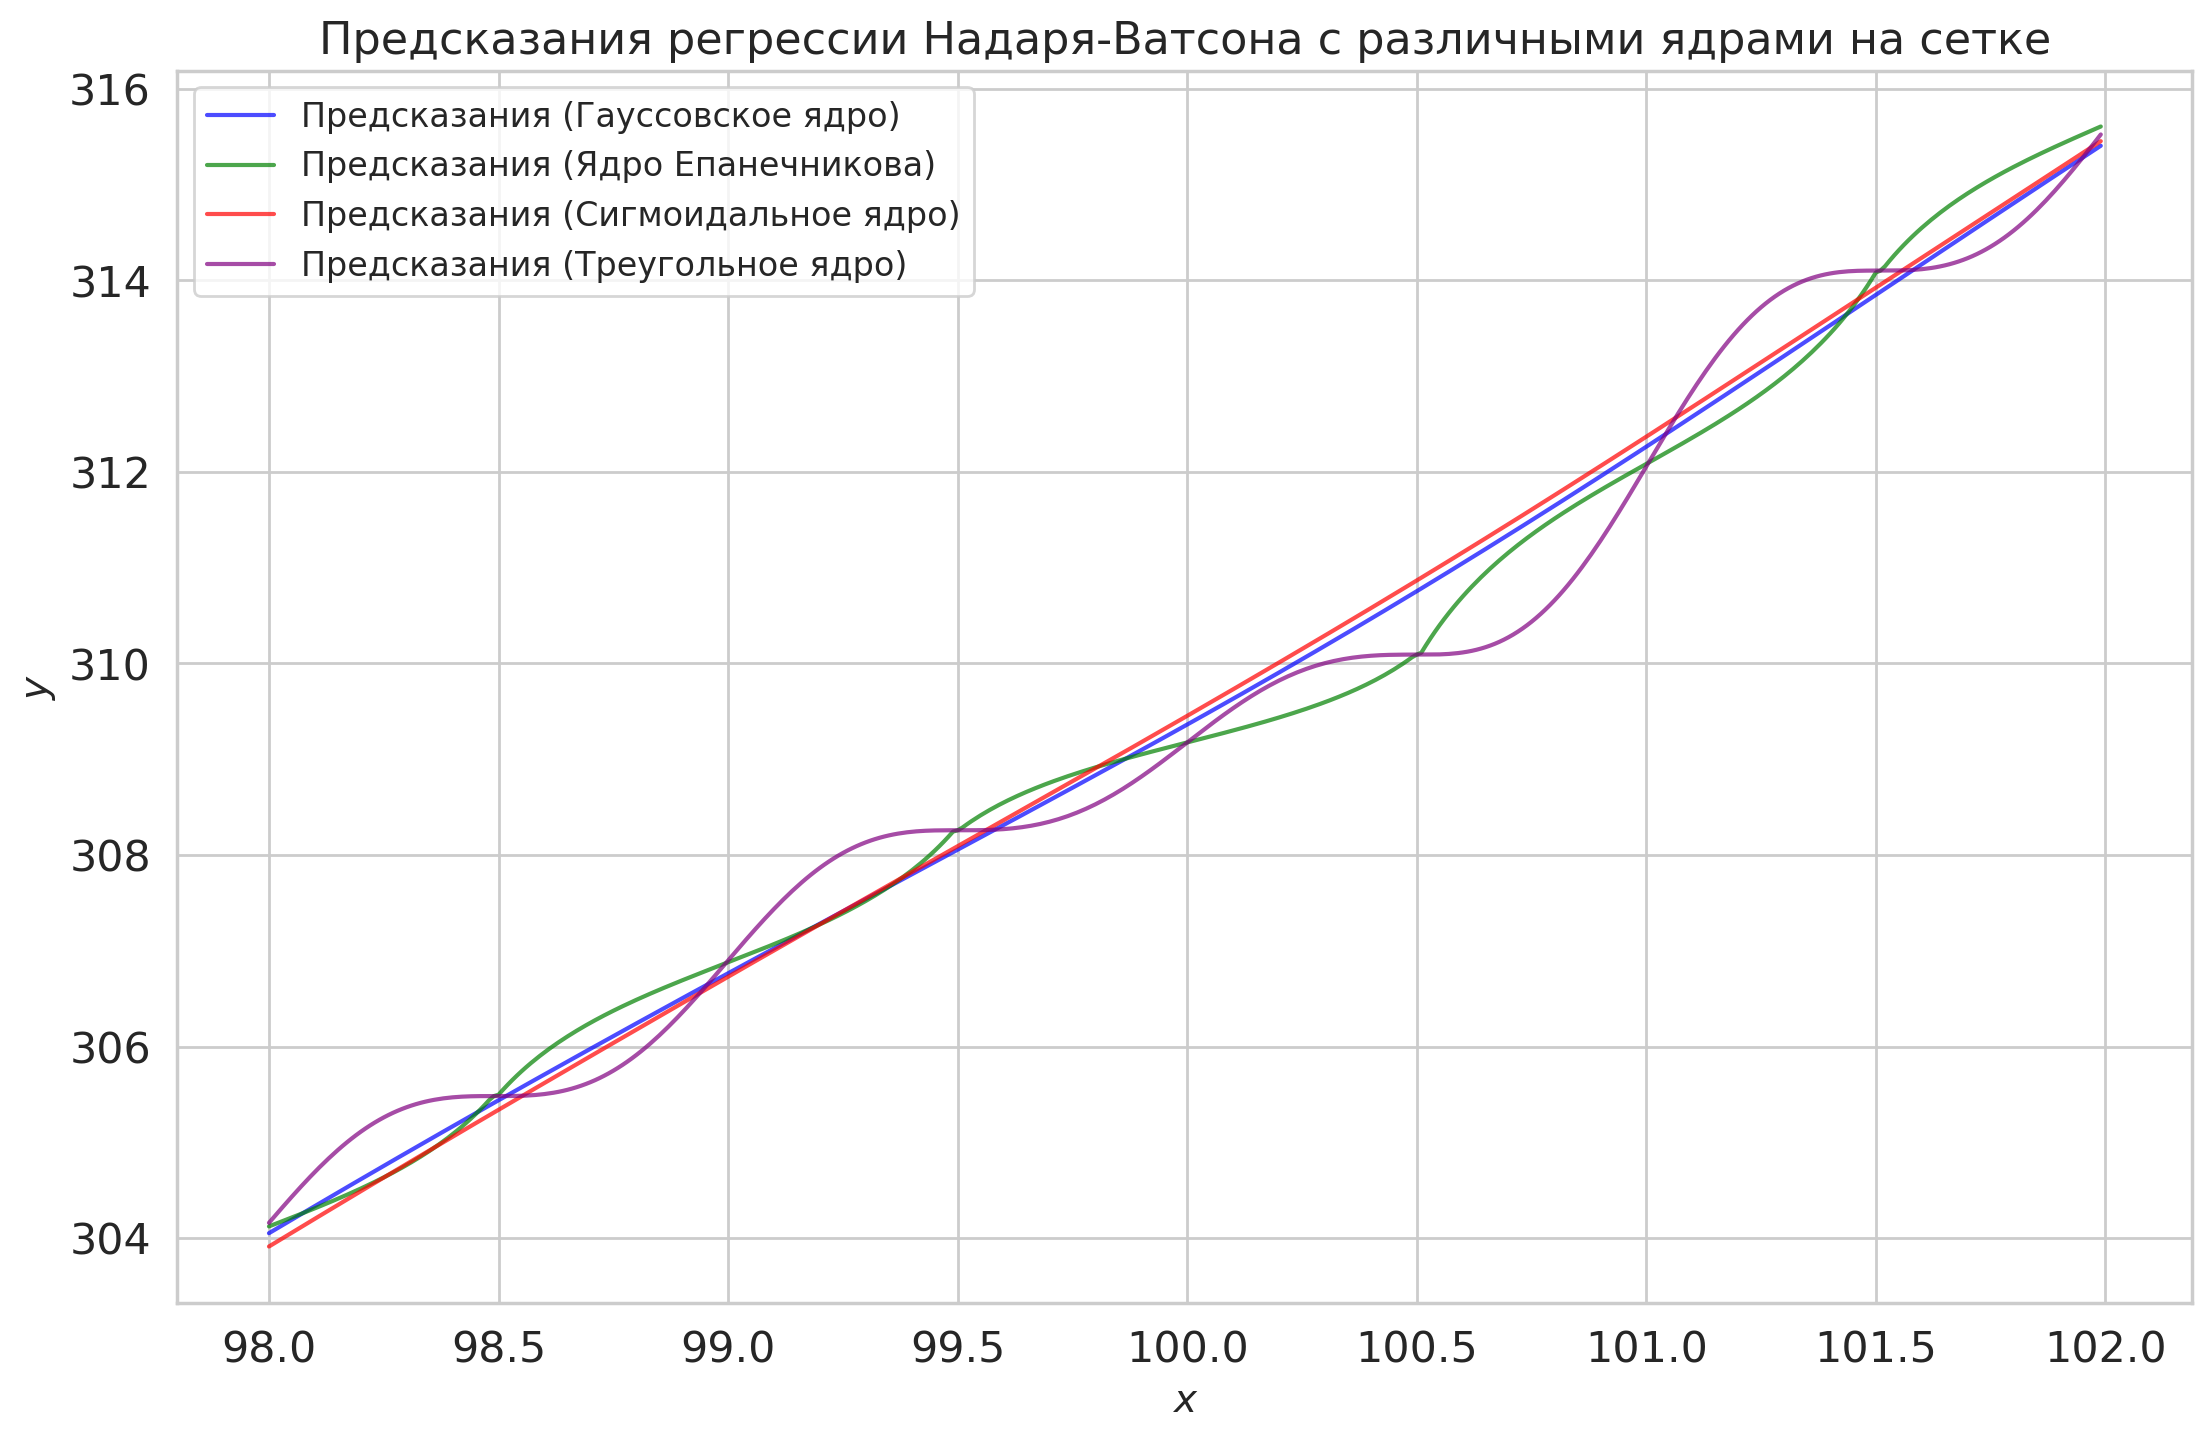

In [193]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(13, 8))

    plt.plot(x_grid, y_gauss, label='Предсказания (Гауссовское ядро)', color='blue', alpha=0.7)
    plt.plot(x_grid, y_epanechniko, label='Предсказания (Ядро Епанечникова)', color='green', alpha=0.7)
    plt.plot(x_grid, y_sigmoid, label='Предсказания (Сигмоидальное ядро)', color='red', alpha=0.7)
    plt.plot(x_grid, y_triangular, label='Предсказания (Треугольное ядро)', color='purple', alpha=0.7)

    plt.xlabel('$x$', fontsize=14)
    plt.ylabel('$y$', fontsize=14)
    plt.title('Предсказания регрессии Надаря-Ватсона с различными ядрами на сетке', fontsize=16)

    plt.legend(fontsize=12)
    plt.show()

Как и ожидалось, у сигмоидального и треугольного ядер на графике будут заметные пики. Однако с увеличением числа значений в обучающей выборке эти пики постепенно сгладятся, пока не достигнут минимального уровня. Этот минимум не будет равен нулю, так как данные изначально содержат гауссовский шум. В то же время, остальные два ядра, похоже, уже достигли максимума своих возможностей, поскольку их предсказания практически неотличимы от прямой.

Заметим, что мы нигде не оценивали сами параметры, но смогли решить финальную задачу -- предсказывать $y$ по $x$.

А теперь поймём, что для этого не нужна линейность.

Проделайте рассуждения выше для нелинейных зависимостей ($y = sin(kx), y = log(x), y = x^k$. Постройте графики предсказаний и сравните их с истинными функциями.

In [253]:
k = 5

n_train = 300
n_test = 10**3

x_train = np.linspace(1e-10, 10, n_train)
x_test = np.linspace(3, 6, n_test)

func = [lambda x : np.sin(k * x), np.log, lambda x : x ** k]
name = [r"$\sin(k x)$", r"$\log(x)$", r"$x^k$"]

scale = [0.1, 0.01, 100]

y_train = [func[i](x_train) + sps.norm.rvs(loc=0, scale=scale[i], size=n_train) for i in range(3)]
y_test = [func[i](x_test) + sps.norm.rvs(loc=0, scale=scale[i], size=n_test) for i in range(3)]

h = [0.1, 0.5, 0.3]

Проведем регрессию (считаем отклик).

In [254]:
y_predicted_gauss = [nadaraya_watson(x_train, y_train[i], x_test, gaussian_kernel, h[i]) for i in range(3)]
y_predicted_epanechniko = [nadaraya_watson(x_train, y_train[i], x_test, epanechnikov_kernel, h[i]) for i in range(3)]
y_predicted_sigmoid = [nadaraya_watson(x_train, y_train[i], x_test, sigmoid_kernel, h[i]) for i in range(3)]
y_predicted_triangular = [nadaraya_watson(x_train, y_train[i], x_test, triangular_kernel, h[i]) for i in range(3)]

Визуализация.

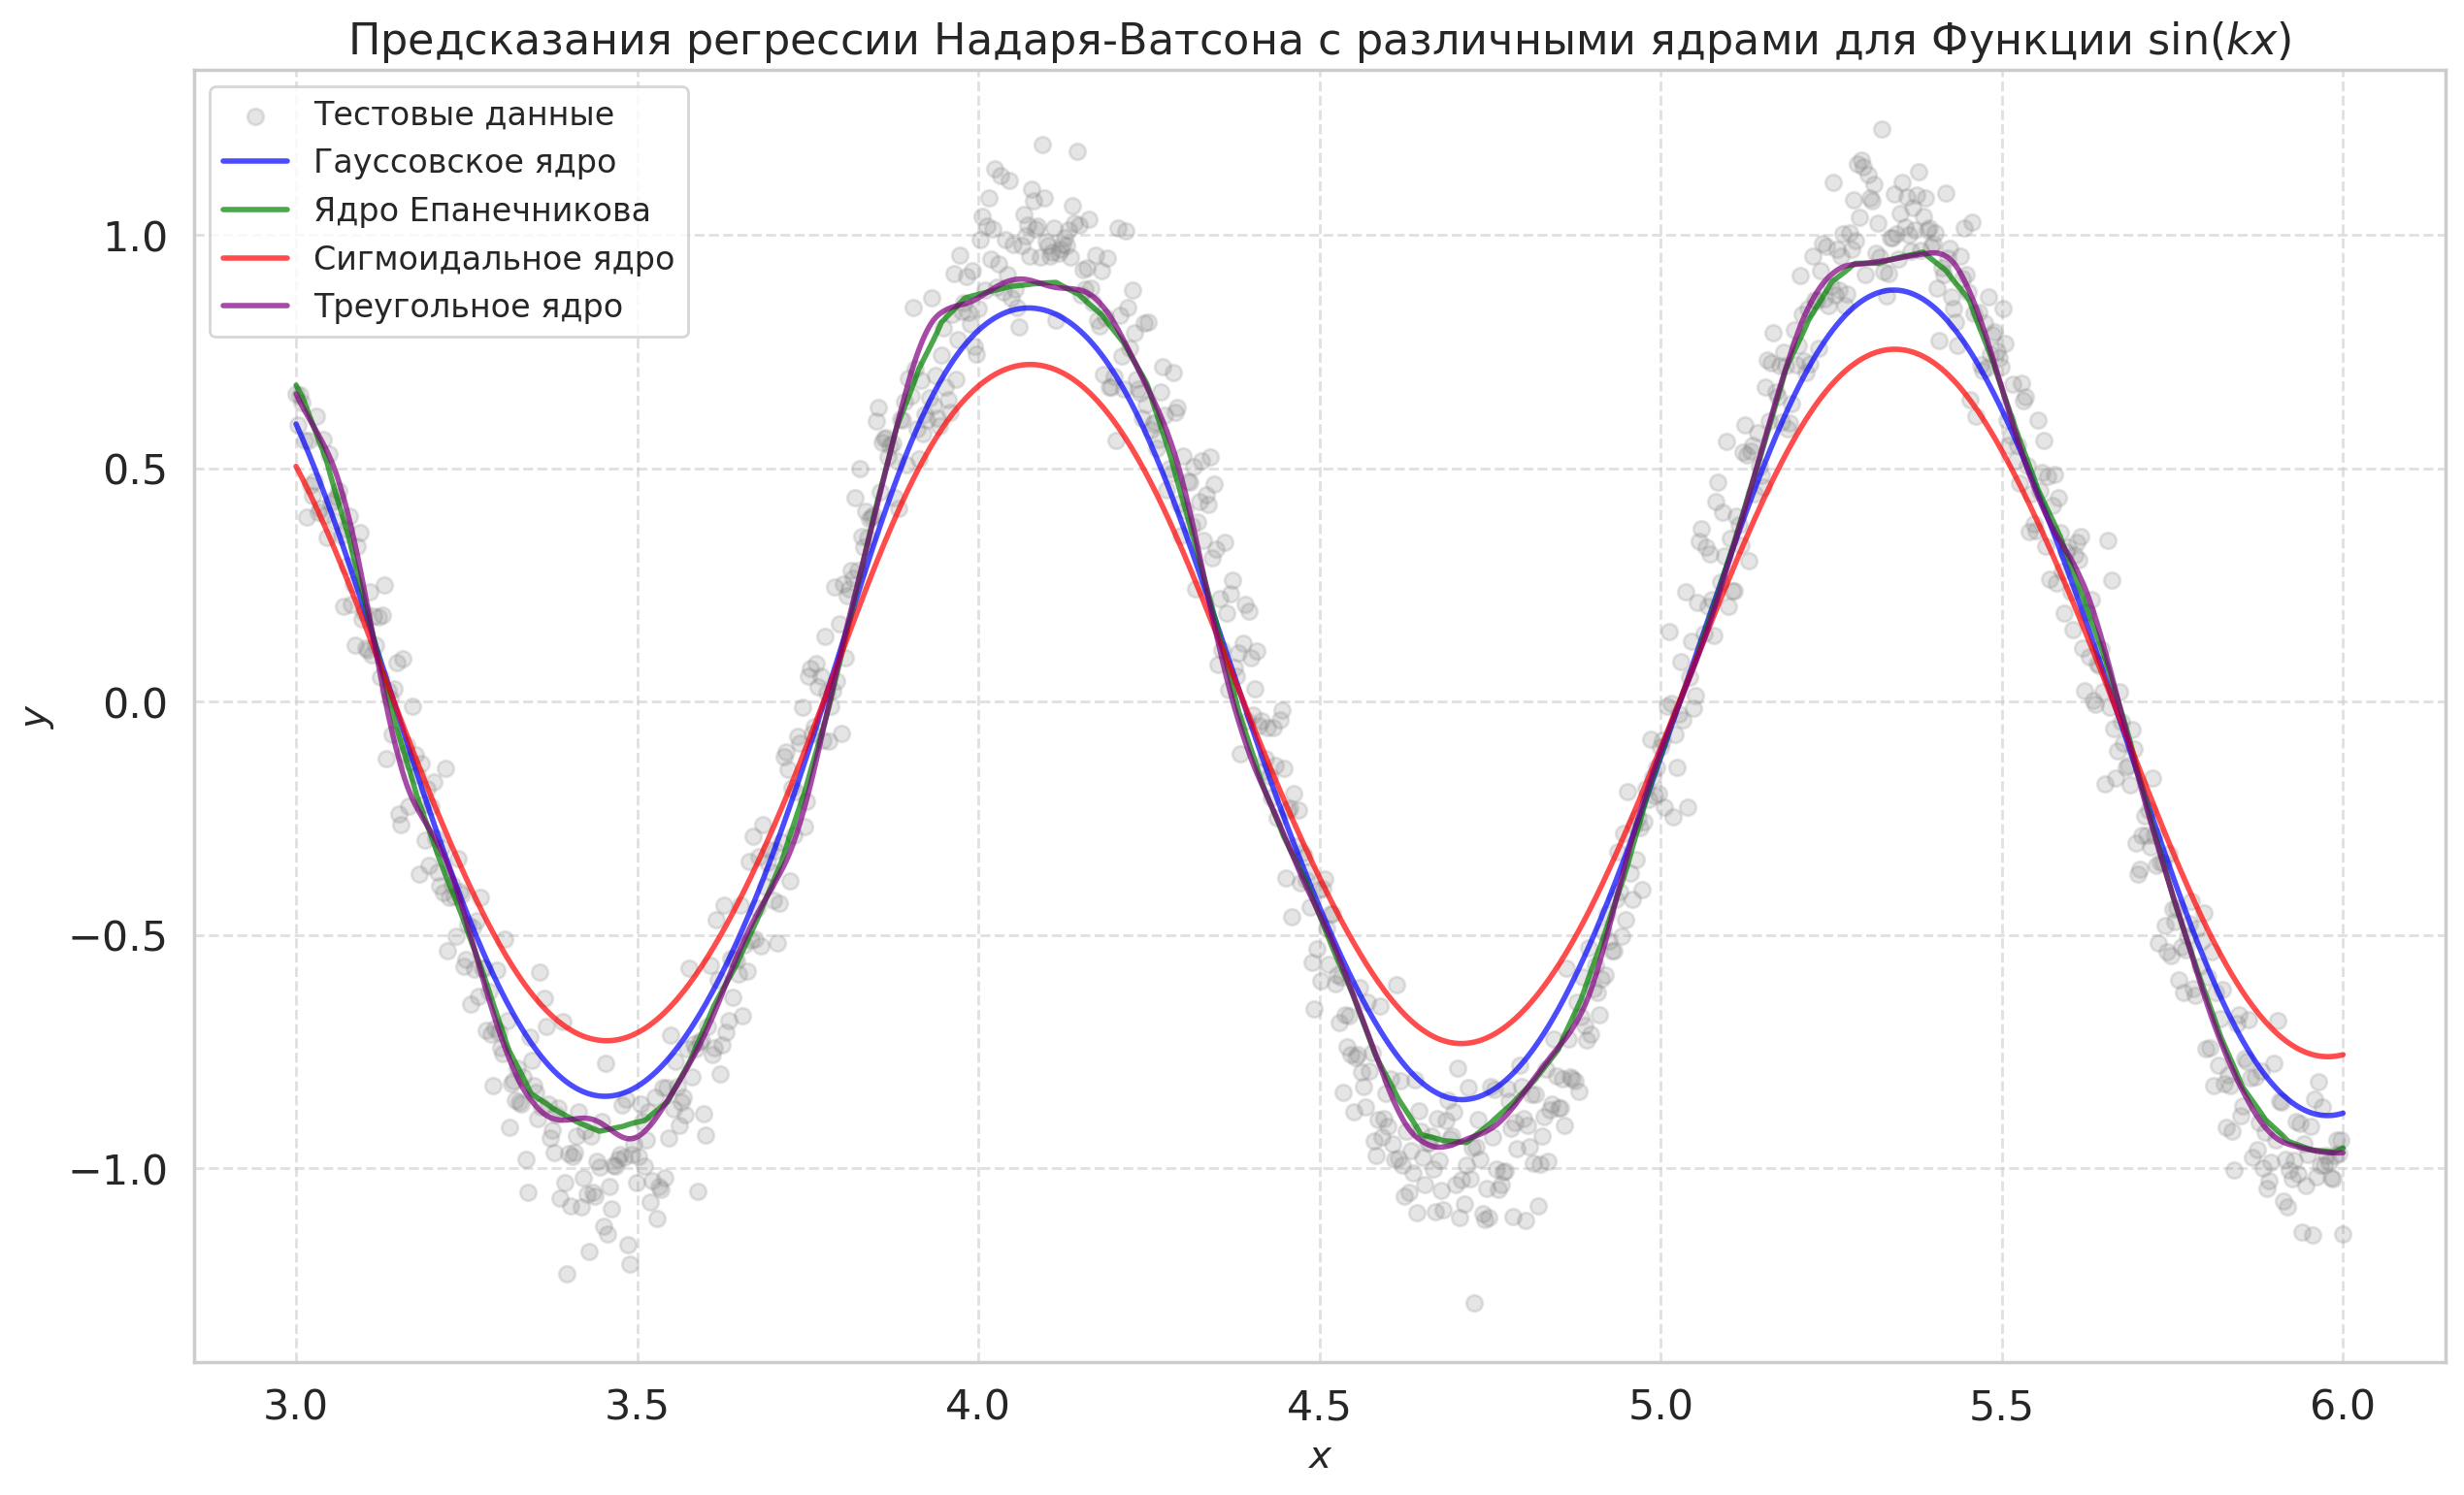

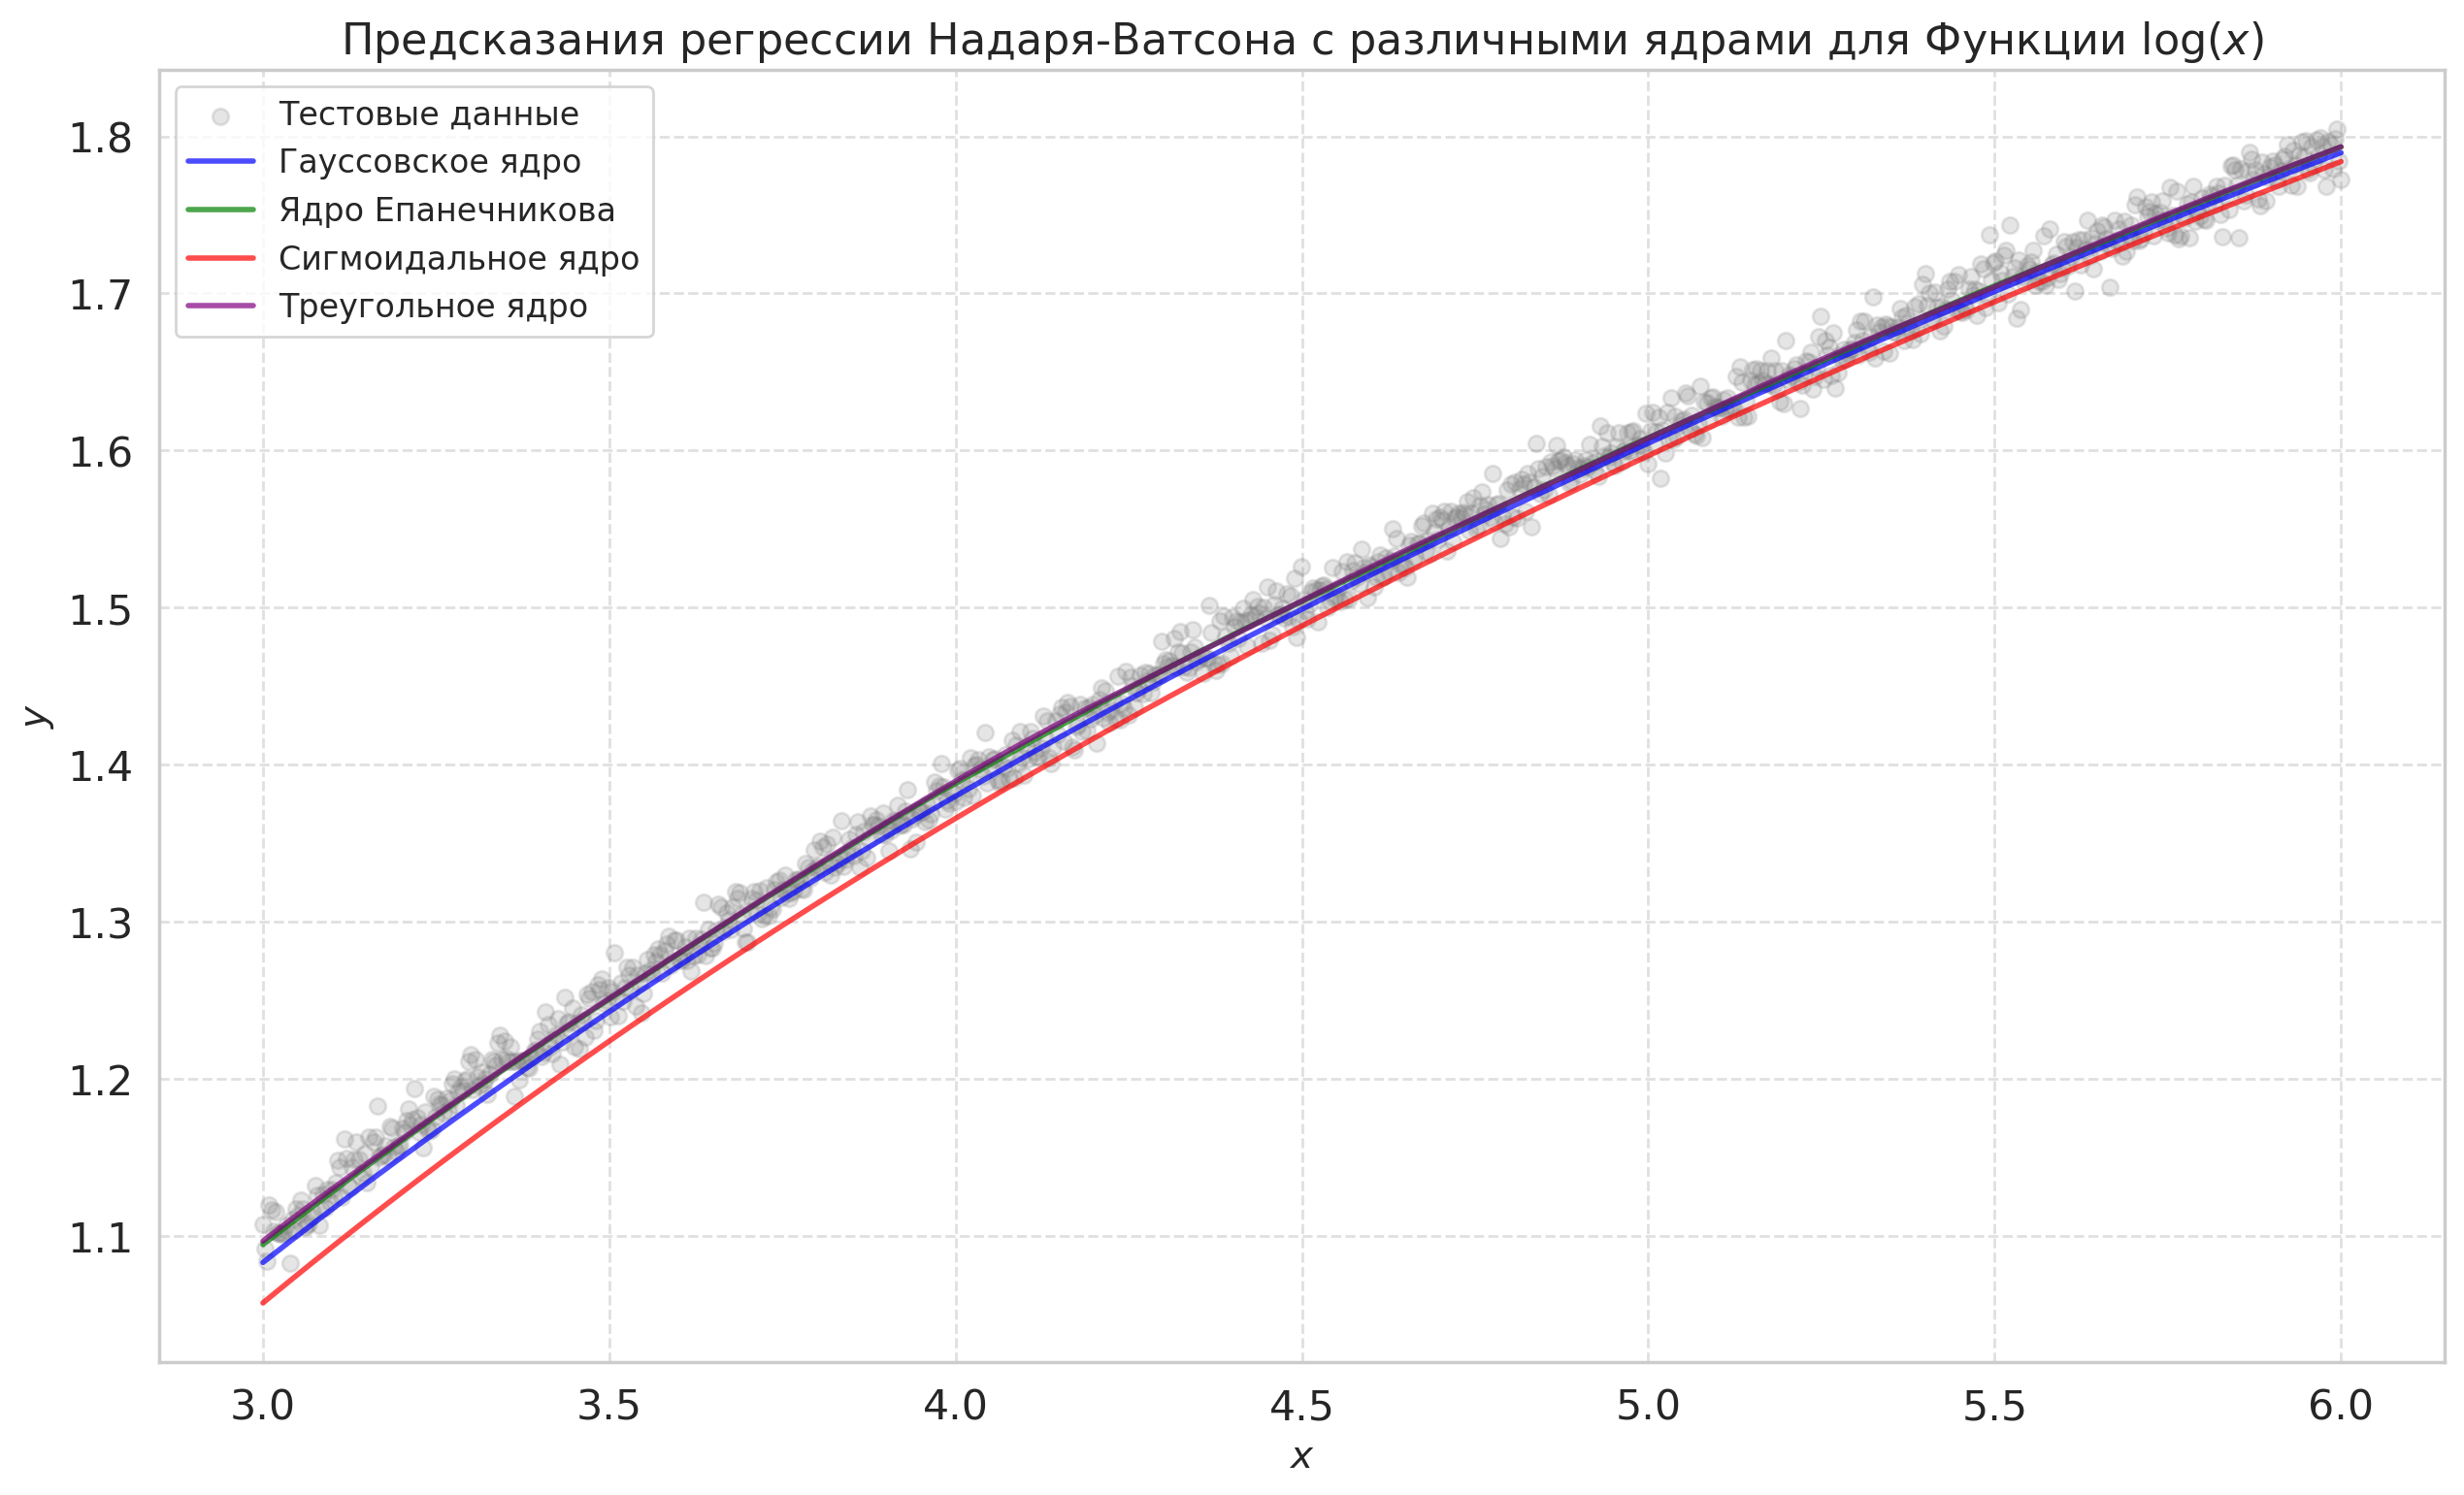

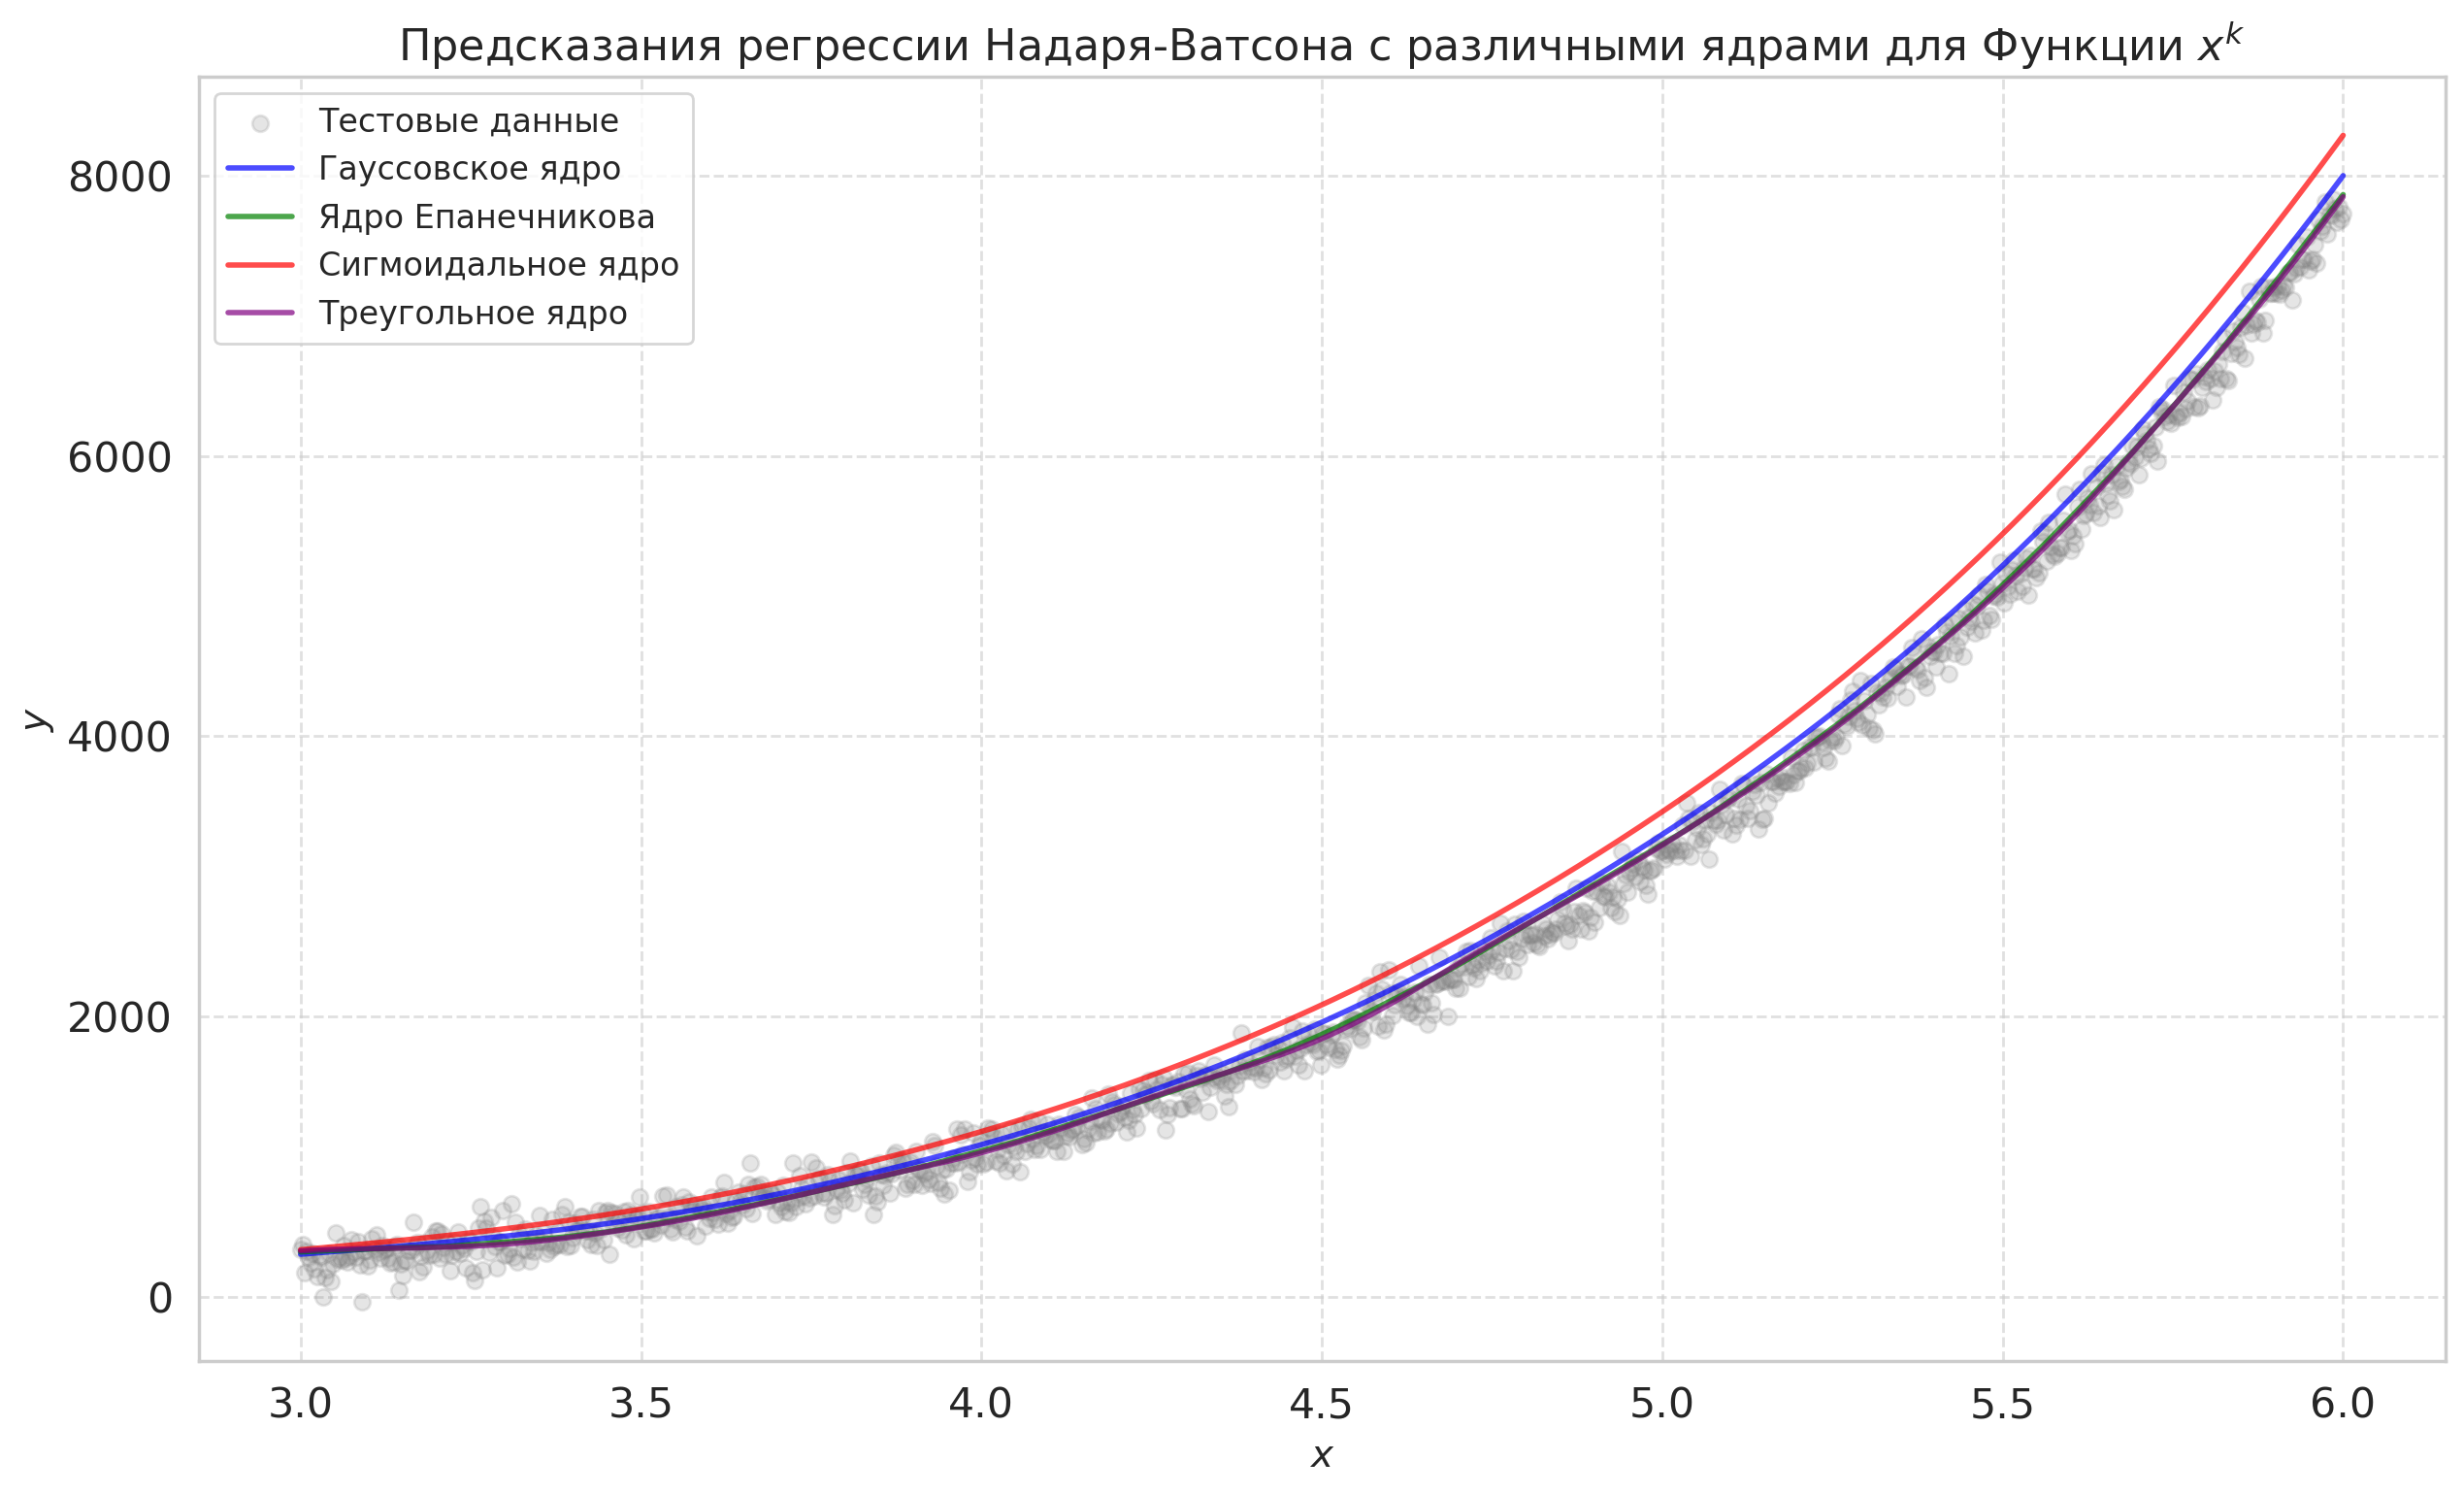

In [255]:
for i in range(len(func)):
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(13, 8))

        plt.scatter(x_test, y_test[i], label='Тестовые данные', color='gray', alpha=0.2)

        plt.plot(x_test, y_predicted_gauss[i], label='Гауссовское ядро', color='blue', alpha=0.7, linewidth=2)
        plt.plot(x_test, y_predicted_epanechniko[i], label='Ядро Епанечникова', color='green', alpha=0.7, linewidth=2)
        plt.plot(x_test, y_predicted_sigmoid[i], label='Сигмоидальное ядро', color='red', alpha=0.7, linewidth=2)
        plt.plot(x_test, y_predicted_triangular[i], label='Треугольное ядро', color='purple', alpha=0.7, linewidth=2)

        plt.xlabel('$x$', fontsize=14)
        plt.ylabel('$y$', fontsize=14)
        plt.title(f'Предсказания регрессии Надаря-Ватсона с различными ядрами для Функции {name[i]}', fontsize=16)

        plt.legend(fontsize=12, loc='best')
        plt.grid(visible=True, which='both', linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

**Вывод:**

При повторении эксперимента можно сразу заметить, за что отвечает параметр $h$ в ядерной регрессии. По сути, это определяет степень влияния соседних точек на предсказание. Слишком маленькое значение $h$ может привести к переобучению, а слишком большое — к чрезмерному усреднению значений. Это особенно заметно для функции синуса: если $h = 1$, то отклик почти везде будет равен 0, так как среднее по такой области будет близко к нулю.

Также можно отметить, что для зависимостей, где значения сильно изменяются (например, синус), лучше использовать ядра с более выраженными пиками, такие как ядро Епанечникова или треугольное ядро. Что касается функций с более плавным поведением, как $x^k$ и $\log⁡(x)$, ядра с высокими пиками тоже демонстрируют хорошие результаты. Однако здесь разница между ядрами менее заметна.

Можете попробовать применить метод Надарая-Ватсона для выборки из задачи 3 и посмотреть, что получится (0 баллов)

## Задача 3 (15 баллов)

Теперь давайте попрактикуемся в решении задач на реальных данных. Мы будем анализировать рынок недвижимости 🏘. Данные возьмем из [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на платформе kaggle. В отличие от соревнований нас будут интересовать зависимости в данных, а не более точные предсказания.

![](https://storage.yandexcloud.net/miptstats-public-files/pictures/housesbanner.png)

В частности мы будем смотреть на влияние различных признаков на стоимость дома и проверим несколько гипотез.

In [256]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe

Downloading...
From: https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe
To: /content/train.csv
100% 461k/461k [00:00<00:00, 126MB/s]


In [44]:
from scipy import stats as sps

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [45]:
df = pd.read_csv("train.csv")

df.fillna("NA", inplace=True)
df.head()

<ipython-input-45-e65b5082c5e9>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("NA", inplace=True)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


Можно заметить, что в данных присутствуют категориальные признаки, которые при этом не лишены порядка.

Вспомните курс машинного обучения. Как можно обработать категориальные призаки, чтобы регрессионная модель была осмысленна?

Ответ:

### Визуализируйте данные

Перед тем, как начать использовать линейные модели необходимо убедиться в том, что столбцы признаков не слишком коллинеарны. Для этого можно использовать [корреляцию Пирсона](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#For_a_sample). Используя ``sns.heatmap`` постройте "тепловую карту" попарных корреляций признаков. Для того, чтобы увидеть числовые значения корреляций используйте ``annot=True``. Сделайте размер графика алекватным, например, ``figsize=(11, 10)``.

Какие признаки Вам кажутся самыми полезными? Выберите 9-10 признаков (пока на основании логики) и визуализируйте только их.

Можете использовать предложенные нами:

useful_columns = [
    "OverallQual",
    "GrLivArea",
    "ExterQual",
    "KitchenQual",
    "GarageArea",
    "PoolArea",
    "BsmtQual",
    "TotalBsmtSF",
    "GarageFinish",
    "SalePrice"
]

In [ ]:
plt.figure(figsize=(11, 10))
sns.heatmap(filtered_df.corr(), annot=True)
plt.show()

Изучите карту и сделайте по ней выводы о зависимости в данных ($|r_{XY}| > 0.9$). А чем плохи зависимые признаки? Для ответа на последний вопрос напишите чему равно аналитическое решение задачи регрессии.

**Ответ:**

Удалите, если требуется, один из двух скоррелированных признаков в ячейке ниже.

Давайте подробнее изучим взаимодействие признаков. Построим матрицу. На диагонале $a_{ii} = d_i$ этой матрицы построим гистограммы для $i$-го признака. На остальных позициях $a_{ij}$ будут располагаться scatterplot в осях признака $i$ по $x$ и признака $j$ по $y$. Для этого можно использовать метод из pandas ``pd.plotting.scatter_matrix``.

Сделайте вывод о данных. Опишите, нужна ли регуляризация и почему?

### Как пользоваться линейными моделями

Как можно догадаться, на практике никто не пишет заново свои линейные модели. Для машинного обучения часто используют библиотеку scikit learn, для аналитики statsmodels. С первой вы познакомитесь (или уже познакомились) на курсе по ML, мы же сконцентрируемся на второй.

Итак, библиотека statsmodels состоит из множества реализованных критериев и, как ни странно, статистических моделей. Основным плюсом является то, что нам не нужно реализовывать критериии вручную, все сделано за нас (это не значит что думать не надо!).

Начнем с линейной модели: для того, чтобы ее создать понадобится лишь одна строка.  Как видно в ячейке ниже мы задаем формулу того, какую модель мы хотим получить. В данном случае мы хотим предсказать ``SalePrice`` по взвешенной сумме из остальных признаков.

In [ ]:
formula = "SalePrice ~ " + " + ".join(useful_columns[:-1])

print(formula)

SalePrice ~ OverallQual + GrLivArea + ExterQual + KitchenQual + GarageArea + PoolArea + BsmtQual + TotalBsmtSF + GarageFinish


Теперь эту формулу мы просто передаем в модель, а так же подаем ей данные. В формуле написаны имена колонок из ``filtered_df``.

In [ ]:
simple_model = smf.ols(formula, data=filtered_df)

fitted_simple_model = simple_model.fit()

print(fitted_simple_model.summary())

### Гетероскедастичность ошибки

**гомоскедастичностью** называют свойство одинаковости дисперсии и независимость остатков модели.

Оценка, полученная с помощью гауссовской линейной модели будет справедлива лишь при выполнении условия гомоскедастичности остатков. Для проверки на гомоскедастичность часто используют критерий Бройша — Пагана. Мы не будем вдаваться в детали и доказательство того, что критерий валидный и работает правильно. Итак, критерий Бройша — Пагана проверяет нулевую гипотезу о гомоскедастичности распределения данных против альтернативы, то есть гетероскедастичности. Если нулевая гипотеза отвергается то можно сказать, что данные распределены ГЕТЕРОскедастично. Мы этого не хотим.

Критерий реализован с помощью функции ``sms.diagnostic.het_breuschpagan``. Документацию можно найти [здесь](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

Остатки модели можно из поля ``fitted_model.resid``, а параметры из ``fitted_model.model.exog``.

Нас интересует p-value для множителя Лагранжа.

В ячейке ниже получите уровень достигаемой значимости для критерия Бройша — Пагана.

In [ ]:
p_val_het = sms.diagnostic.het_breuschpagan(resid=fitted_simple_model.resid,
                                            exog_het=fitted_simple_model.model.exog)[1]

print(f"p-value simple: {p_val_het}")

p-value simple: 5.431361130993936e-95


Пока не вдаваясь в проверку гипотез просто будем считать, что критерий точно проверяет условие гомоскедастичности.

Отвергается ли гипотеза о гомоскедастичности остатков (определение из будущего: гипотеза отвергается, если pvalue < 0.05 и это значит, что её утверждение полагается неверным)? Что это означает?

**Ответ:**

В случаях, когда распределения остатков не является гомоскедастичном оценка по-прежнему остается несмещенной, однако стоит сделать некоторую поправку, на более высокую дисперсию. Поэтому значения F-критериев и t-критериев для коэффициентов стоит пересмотреть. Для таких случаев существует достаточно много различных поправок, одно из семейств таких поправок называется поправки Уайта на гетероскедастичность. Ниже мы попробуем использовать одну из поправок.

Для этого, в ячейке ниже, обучите линейную модель, но на этот раз передайте в метод ``.fit`` аргумент ``cov_type="HC1"``.

Получите summary для такой модели.

Проанализируйте результаты. Как изменились показатели из таблицы?

**Ответ:**

Теперь мы действительно можем оценивать то, насколько важен тот или иной признак.



Проведите отбор признаков методами с семинара. Начните с того, что выберите около 15 признаков, которые Вам кажутся разумными и отберите лучшие 3, 5 и 10 из них.

Какие признаки оказались не значимы и почему?

**Ответ:**

Теперь снова обучим новую модель только на значимых признаках и получим summary. Не забудьте про поправку Уайта!

Как изменился коэффициент $R^2$? Всегда ли бОльший $R^2$ говорит о правильной модели? Расскажите о своих рассуждениях!

**Ответ:**

### Преобразование целевого признака

Обратим свое внимание на целевую переменную. Ниже постройте гистограммы для признака ``SalePrice``. А так же для логарифма от ``SalePrice``. Сделайте это на разных картинках. Можно использовать subplot.

Какой из графиков выглядит более "Гауссовским"?

**Ответ:**

Теперь давайте снова посмотрим на распределение остатков от линейной модели. Начертим qqplot для нормального распределения и гистограмму остатков.

Как вы считаете, можно ли сказать, что распределение остатков это нормальное распределение?

**Ответ:**

Давайте обучим модель предсказывать не SalePrice, а ее логарифм. Для этого снова обновим формулу для модели. Прелесть формул в том, что в них можно использовать операции из numpy. Например можно искать зависимость не от ``PoolArea``, а от ее квадрата, то есть ``np.power(PoolArea, 2)``. Достаточно просто добавить в формулу ..." + np.power(PoolArea, 2)" и все заработает!

В ячейке ниже обучите модель предсказывать логарифм SalePrice. Получите summary этой модели.

Как изменился коэффициент R^2? Модель лучше стала понимать данные?

**Ответ:**

Постройте графики, аналогичные тем, что встретились нам на две ячейки выше (qqplot и гистограмму остатков). Но на этот раз для модели, предсказывающией логарифм.

Как вы считаете, стоит ли предсказывать логарифм от цены? В каких случаях это полезно?

**Ответ:**

## Бонусная часть (20 баллов)

Подойдём к задаче регрессии с байесовской точки зрения. Полезно изучить разделы 8.1, 8.2 конспекта Д.П.Вектрова (https://vk.com/doc126754362_500465695?hash=uU7RYUtCmrntB7ynduiZlYgZuR5C4oSnXqB5nXW0DEk&dl=votNcsozZKYk4ZLO546dYTZd17B3eHok2xSVQP6F6ic)

Только в начале дочитайте задание, а потом лезьте в конспект.

Мы Вам предлагаем увидеть, как при помощи байесовского подхода выбрать важные признаки регрессионной модели. Рекомендуем проделать выкладки без "подглядывания" в конспект.

1) Запишите байесовскую постановку задачи регрессии. Не забудьте про априорное распределение -- регуляризацию (пусть она для всех компонент одинаковая). Регуляризовать будем нормальным распределением, более того считать его компоненты независимыми (матрица ковариаций будет диагональна)

2) Каким будет аналитическое решение, если бы мы реализовывали "байес для бедных"? Какую роль играет регуляризация?

3) Теперь, когда Вы выяснили роль регуляризации давайте вместо диагональной матрицы с одинаковыми значениями на диагонали в качестве априорного распределения возьмём разные значения. Как изменится решение? Что произойдёт с теми признаками, у которых априорная дисперсия высокая? А низкая?

4) В вариационном байесовском выводе у Вас появился интересный объект в знаменателе -- интеграл по всему пространству параметров от регуляризированного правдоподобия. Это называется *обоснованностью* параметрической модели. Чем она выше -- тем лучше заданное семейство распределений описывает Ваши данные.

Прочитайте статью на википедии о бритве Оккама и критерии фальсифицируемости Поппера и ещё раз посмотрите на знаменатель. Порассуждайте о том, почему более обоснованные модели выше.

**Ваш философский ответ:**

А теперь откройте главу 8 конспекта Ветрова и изучите алгоритм максимизации обоснованности.

Напишите его.

Изучите дисперсии, которые получатся после 30 итераций (или сколько Вам понадобится для сходимости). Подумайте, почему алгоритм счёл одни признаки полезнее других. Визуализируйте распределение признака и его дисперсию. Сделайте выводы.

**Вывод:**